In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_df=pd.read_csv('/kaggle/input/rvf10k/train.csv')
valid_df=pd.read_csv('/kaggle/input/rvf10k/valid.csv')

In [3]:
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [6]:
class FacesDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 5])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Define una transformación para convertir las imágenes a tensores para luego normalizarlas
# def calculus_transform(image) -> torch.Tensor:
#     transform = transforms.ToTensor()
#     return transform(image)

calculus_transform = transforms.ToTensor()


# Variables para calcular la media y la desviación estándar
mean = 0.
std = 0.
total_samples = 0

calculus_dataset = FacesDataset(dataframe=train_df, root_dir='/kaggle/input/rvf10k/rvf10k/', transform=calculus_transform)
# Crea un DataLoader para iterar sobre el conjunto de datos
calculus_loader = torch.utils.data.DataLoader(calculus_dataset, batch_size=1000, shuffle=True)


for images, _ in calculus_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_samples += batch_samples

# Calcula la media y la desviación estándar finales
mean /= total_samples
std /= total_samples

print("Mean:", mean.numpy())
print("Std:", std.numpy())

Mean: [0.5212097  0.42598605 0.38105515]
Std: [0.24863924 0.22383371 0.22106402]


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy()),
])

In [9]:
transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ColorJitter(saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy())
])

In [10]:
# custom datasets
train_dataset = FacesDataset(dataframe=train_df, root_dir='/kaggle/input/rvf10k/rvf10k/', transform=transform)
valid_dataset = FacesDataset(dataframe=valid_df, root_dir='/kaggle/input/rvf10k/rvf10k/', transform=transform)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [11]:
# custom datasets
train_dataset_aug = FacesDataset(dataframe=train_df, root_dir='/kaggle/input/rvf10k/rvf10k/', transform=transform_aug)
valid_dataset_aug = FacesDataset(dataframe=valid_df, root_dir='/kaggle/input/rvf10k/rvf10k/', transform=transform)

# data loaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
valid_loader_aug = DataLoader(valid_dataset_aug, batch_size=32, shuffle=False)

### Nuestra función de train

In [13]:
def train(model, optimizer, criterion, metric, data, epochs):

    train_loader = data["train"]
    valid_loader = data["valid"]

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target.float())
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target.float()).item()
            epoch_valid_accuracy += metric(output, valid_target.float()).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def plot_history(history):

    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history["train_loss"])
    axs[0].plot(history["valid_loss"])
    axs[0].title.set_text('Error de Entrenamiento vs Validación')
    axs[0].legend(['Train', 'Valid'])

    axs[1].plot(history["train_acc"])
    axs[1].plot(history["valid_acc"])
    axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
    axs[1].legend(['Train', 'Valid'])

In [16]:
def evaluate_model(model, valid_loader, metric):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            #_, predicted = torch.max(outputs, 1)
            predicted = outputs
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # print(f'Accuracy: {accuracy_score(all_labels, all_preds)}')
    # metric_result = metric(all_preds, all_labels)
    metric_result = metric(torch.tensor(all_preds), torch.tensor(all_labels))
    print(f'Accuracy: {metric_result}')

    # report
    all_preds_binary = [1 if value > 0.5 else 0 for value in all_preds]

    print("Classification Report:")
    print(classification_report(all_labels, all_preds_binary))

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds_binary)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [19]:
# Definimos una función que plotee los resultados
def plot_predictions(model,
                     valid_loader,
                     label_map = {0: 'fake', 1: 'real'},
                     device = device):
    plt.figure(figsize=(10, 10))

    images, labels = next(iter(valid_loader))

    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # _, predicted = torch.max(outputs, 1)
    predicted = outputs
    predicted_binary = [1 if value > 0.5 else 0 for value in predicted]

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        color = 'green' if predicted_binary[i] == labels[i] else 'red'
        plt.title(f'Actual: {label_map[int(labels[i])]}, Predicted: {label_map[predicted_binary[i]]}', color=color)
        plt.axis('off')

    plt.show()

### Vemos un nuevo modelo

In [22]:
class FacesImprovedCNN(nn.Module):
    def __init__(self):
        super(FacesImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.final = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.final(x)
        return x.squeeze()

### Probamos con los datos sin hacer augmentation

In [26]:
# cantidad_clases = 2
images_width = 224
images_height = 224
improved_model = FacesImprovedCNN()
optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.0001)
# loss = torch.nn.CrossEntropyLoss()
loss = torch.nn.BCELoss()
# metric = torchmetrics.Accuracy(task='multiclass', num_classes=cantidad_clases)
metric = torchmetrics.classification.BinaryAccuracy()
data = {"train": train_loader, "valid": valid_loader, "image_width": images_width, "image_height": images_height}

history = train(improved_model,
                optimizer,
                loss,
                metric,
                data,
                20)

Epoch: 1/20 - Train loss 0.788678 - Train Accuracy 0.632373 - Valid Loss 0.596117 - Valid Accuracy 0.678302
Epoch: 2/20 - Train loss 0.566301 - Train Accuracy 0.706764 - Valid Loss 0.543700 - Valid Accuracy 0.725510
Epoch: 3/20 - Train loss 0.516559 - Train Accuracy 0.746052 - Valid Loss 0.575662 - Valid Accuracy 0.692154
Epoch: 4/20 - Train loss 0.463837 - Train Accuracy 0.781773 - Valid Loss 0.458941 - Valid Accuracy 0.785018
Epoch: 5/20 - Train loss 0.405057 - Train Accuracy 0.817114 - Valid Loss 0.436943 - Valid Accuracy 0.799313
Epoch: 6/20 - Train loss 0.358856 - Train Accuracy 0.847412 - Valid Loss 0.414577 - Valid Accuracy 0.809397
Epoch: 7/20 - Train loss 0.313188 - Train Accuracy 0.869007 - Valid Loss 0.448482 - Valid Accuracy 0.787566
Epoch: 8/20 - Train loss 0.284505 - Train Accuracy 0.882468 - Valid Loss 0.376138 - Valid Accuracy 0.833333
Epoch: 9/20 - Train loss 0.239550 - Train Accuracy 0.907011 - Valid Loss 0.374422 - Valid Accuracy 0.828790
Epoch: 10/20 - Train loss 0.

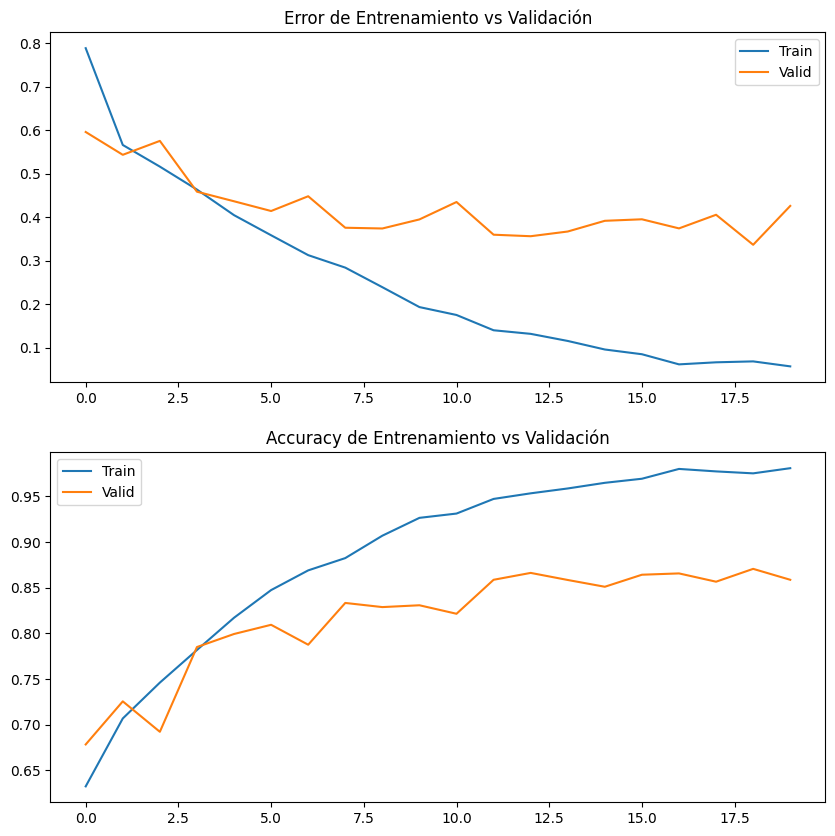

In [27]:
plot_history(history)

Accuracy: 0.8586666584014893
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1500
           1       0.88      0.83      0.85      1500

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



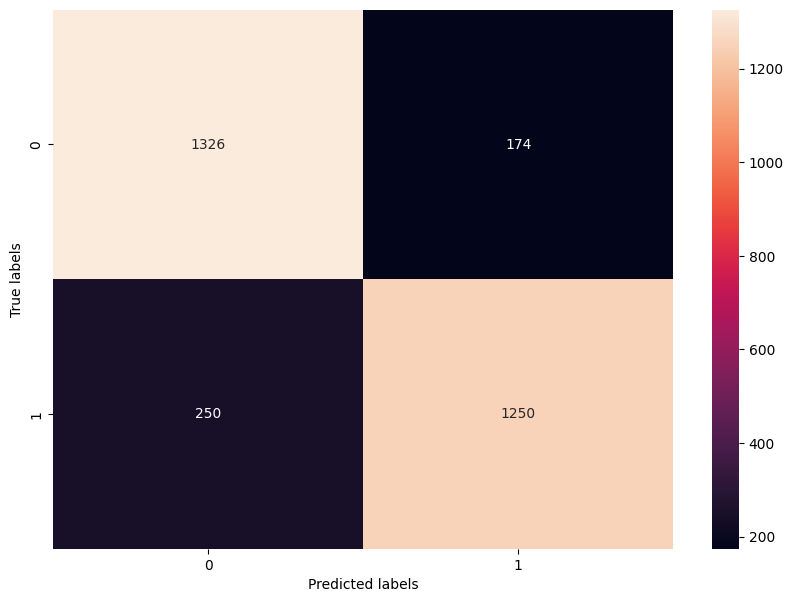

In [28]:
evaluate_model(improved_model, valid_loader, metric)

## ¿Por qué la normalización por lotes mejora la precisión final?

La normalización por lotes (batch normalization) es una técnica común en redes neuronales convolucionales (CNNs) que mejora significativamente la precisión final del modelo. 

**Aquí hay algunas razones clave por las que la normalización por lotes es beneficiosa:**

**1. Acelera el entrenamiento:**

- La normalización por lotes estabiliza la distribución de las entradas a cada capa de la red neuronal, lo que permite utilizar tasas de aprendizaje más altas.
- Esto puede acelerar el proceso de entrenamiento y permitir que la red converja en una mejor solución en menos tiempo.

**2. Reduce el sobreajuste:**

- La normalización por lotes ayuda a evitar que las redes neuronales se ajusten demasiado a los datos de entrenamiento.
- Esto se debe a que la normalización por lotes asegura que cada capa reciba entradas con una distribución similar, lo que dificulta que la red se adapte a patrones específicos en los datos de entrenamiento que no se generalizan a los datos no vistos.

**3. Mejora la generalización:**

- La reducción del sobreajuste conduce a una mejor generalización, lo que significa que la red neuronal puede funcionar mejor en datos nuevos que no se utilizaron para entrenarla.
- Esto es crucial para crear modelos robustos que puedan ser utilizados en aplicaciones del mundo real.

**4. Facilita la inicialización de pesos:**

- La normalización por lotes hace que las redes neuronales sean menos sensibles a la inicialización de los pesos.
- Esto significa que no es tan importante elegir cuidadosamente los valores iniciales de los pesos, lo que simplifica el proceso de entrenamiento.

**5. Permite utilizar funciones de activación no lineales:**

- La normalización por lotes permite utilizar funciones de activación no lineales, como ReLU, sin que la red se vuelva inestable.
- Estas funciones de activación son importantes para permitir que la red aprenda relaciones complejas en los datos.

En resumen, la normalización por lotes es una técnica poderosa que mejora el rendimiento de las CNNs de diversas maneras. Es una técnica ampliamente utilizada en el aprendizaje profundo y se considera una parte esencial del entrenamiento de redes neuronales convolucionales.
